<a href="https://colab.research.google.com/github/Wilma1088/mypackage/blob/master/Zindi_Challenge_V8ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [261]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVR

from tqdm import tqdm
import math
import random

from scipy.stats import norm, skew #for some statistics

from google.colab import files
import io

In [174]:
uploaded = files.upload()

Saving Riders.csv to Riders (1).csv
Saving Test.csv to Test (1).csv
Saving Train.csv to Train (1).csv


In [175]:
riders_df = pd.read_csv(io.BytesIO(uploaded['Riders.csv']))
riders_df.columns= [col.replace(' ', '_') for col in riders_df.columns]
riders_df.head()

,Rider_Id,No_Of_Orders,Age,Average_Rating,No_of_Ratings
0,Rider_Id_396,2946,2298,14.0,1159
1,Rider_Id_479,360,951,13.5,176
2,Rider_Id_648,1746,821,14.3,466
3,Rider_Id_753,314,980,12.5,75
4,Rider_Id_335,536,1113,13.7,156


In [176]:
test_df = pd.read_csv(io.BytesIO(uploaded['Test.csv']))
test_df.columns= [col.replace(' ', '_') for col in test_df.columns]
test_df.head()

,Order_No,User_Id,Vehicle_Type,Platform_Type,Personal_or_Business,Placement_-_Day_of_Month,Placement_-_Weekday_(Mo_=_1),Placement_-_Time,Confirmation_-_Day_of_Month,Confirmation_-_Weekday_(Mo_=_1),Confirmation_-_Time,Arrival_at_Pickup_-_Day_of_Month,Arrival_at_Pickup_-_Weekday_(Mo_=_1),Arrival_at_Pickup_-_Time,Pickup_-_Day_of_Month,Pickup_-_Weekday_(Mo_=_1),Pickup_-_Time,Distance_(KM),Temperature,Precipitation_in_millimeters,Pickup_Lat,Pickup_Long,Destination_Lat,Destination_Long,Rider_Id
0,Order_No_19248,User_Id_3355,Bike,3,Business,27,3,4:44:10 PM,27,3,4:44:29 PM,27,3,4:53:04 PM,27,3,5:06:47 PM,8,NaN,NaN,-1.333275,36.870815,-1.305249,36.822390,Rider_Id_192
1,Order_No_12736,User_Id_3647,Bike,3,Business,17,5,12:57:35 PM,17,5,12:59:17 PM,17,5,1:20:27 PM,17,5,1:25:37 PM,5,NaN,NaN,-1.272639,36.794723,-1.277007,36.823907,Rider_Id_868
2,Order_No_768,User_Id_2154,Bike,3,Business,27,4,11:08:14 AM,27,4,11:25:05 AM,27,4,11:33:20 AM,27,4,11:57:54 AM,5,22.8,NaN,-1.290894,36.822971,-1.276574,36.851365,Rider_Id_26
3,Order_No_15332,User_Id_2910,Bike,3,Business,17,1,1:51:35 PM,17,1,1:53:27 PM,17,1,2:02:41 PM,17,1,2:16:52 PM,5,24.5,NaN,-1.290503,36.809646,-1.303382,36.790658,Rider_Id_685
4,Order_No_21373,User_Id_1205,Bike,3,Business,11,2,11:30:28 AM,11,2,11:34:45 AM,11,2,11:47:19 AM,11,2,11:56:04 AM,6,24.4,NaN,-1.281081,36.814423,-1.266467,36.792161,Rider_Id_858


In [177]:
train_df = pd.read_csv(io.BytesIO(uploaded['Train.csv']))
train_df.columns= [col.replace(' ', '_') for col in train_df.columns]
train_df.head()

,Order_No,User_Id,Vehicle_Type,Platform_Type,Personal_or_Business,Placement_-_Day_of_Month,Placement_-_Weekday_(Mo_=_1),Placement_-_Time,Confirmation_-_Day_of_Month,Confirmation_-_Weekday_(Mo_=_1),Confirmation_-_Time,Arrival_at_Pickup_-_Day_of_Month,Arrival_at_Pickup_-_Weekday_(Mo_=_1),Arrival_at_Pickup_-_Time,Pickup_-_Day_of_Month,Pickup_-_Weekday_(Mo_=_1),Pickup_-_Time,Arrival_at_Destination_-_Day_of_Month,Arrival_at_Destination_-_Weekday_(Mo_=_1),Arrival_at_Destination_-_Time,Distance_(KM),Temperature,Precipitation_in_millimeters,Pickup_Lat,Pickup_Long,Destination_Lat,Destination_Long,Rider_Id,Time_from_Pickup_to_Arrival
0,Order_No_4211,User_Id_633,Bike,3,Business,9,5,9:35:46 AM,9,5,9:40:10 AM,9,5,10:04:47 AM,9,5,10:27:30 AM,9,5,10:39:55 AM,4,20.4,NaN,-1.317755,36.830370,-1.300406,36.829741,Rider_Id_432,745
1,Order_No_25375,User_Id_2285,Bike,3,Personal,12,5,11:16:16 AM,12,5,11:23:21 AM,12,5,11:40:22 AM,12,5,11:44:09 AM,12,5,12:17:22 PM,16,26.4,NaN,-1.351453,36.899315,-1.295004,36.814358,Rider_Id_856,1993
2,Order_No_1899,User_Id_265,Bike,3,Business,30,2,12:39:25 PM,30,2,12:42:44 PM,30,2,12:49:34 PM,30,2,12:53:03 PM,30,2,1:00:38 PM,3,NaN,NaN,-1.308284,36.843419,-1.300921,36.828195,Rider_Id_155,455
3,Order_No_9336,User_Id_1402,Bike,3,Business,15,5,9:25:34 AM,15,5,9:26:05 AM,15,5,9:37:56 AM,15,5,9:43:06 AM,15,5,10:05:27 AM,9,19.2,NaN,-1.281301,36.832396,-1.257147,36.795063,Rider_Id_855,1341
4,Order_No_27883,User_Id_1737,Bike,1,Personal,13,1,9:55:18 AM,13,1,9:56:18 AM,13,1,10:03:53 AM,13,1,10:05:23 AM,13,1,10:25:37 AM,9,15.4,NaN,-1.266597,36.792118,-1.295041,36.809817,Rider_Id_770,1214


In [178]:
df=pd.concat([train_df, test_df])
df.head()

,Order_No,User_Id,Vehicle_Type,Platform_Type,Personal_or_Business,Placement_-_Day_of_Month,Placement_-_Weekday_(Mo_=_1),Placement_-_Time,Confirmation_-_Day_of_Month,Confirmation_-_Weekday_(Mo_=_1),Confirmation_-_Time,Arrival_at_Pickup_-_Day_of_Month,Arrival_at_Pickup_-_Weekday_(Mo_=_1),Arrival_at_Pickup_-_Time,Pickup_-_Day_of_Month,Pickup_-_Weekday_(Mo_=_1),Pickup_-_Time,Arrival_at_Destination_-_Day_of_Month,Arrival_at_Destination_-_Weekday_(Mo_=_1),Arrival_at_Destination_-_Time,Distance_(KM),Temperature,Precipitation_in_millimeters,Pickup_Lat,Pickup_Long,Destination_Lat,Destination_Long,Rider_Id,Time_from_Pickup_to_Arrival
0,Order_No_4211,User_Id_633,Bike,3,Business,9,5,9:35:46 AM,9,5,9:40:10 AM,9,5,10:04:47 AM,9,5,10:27:30 AM,9.0,5.0,10:39:55 AM,4,20.4,NaN,-1.317755,36.830370,-1.300406,36.829741,Rider_Id_432,745.0
1,Order_No_25375,User_Id_2285,Bike,3,Personal,12,5,11:16:16 AM,12,5,11:23:21 AM,12,5,11:40:22 AM,12,5,11:44:09 AM,12.0,5.0,12:17:22 PM,16,26.4,NaN,-1.351453,36.899315,-1.295004,36.814358,Rider_Id_856,1993.0
2,Order_No_1899,User_Id_265,Bike,3,Business,30,2,12:39:25 PM,30,2,12:42:44 PM,30,2,12:49:34 PM,30,2,12:53:03 PM,30.0,2.0,1:00:38 PM,3,NaN,NaN,-1.308284,36.843419,-1.300921,36.828195,Rider_Id_155,455.0
3,Order_No_9336,User_Id_1402,Bike,3,Business,15,5,9:25:34 AM,15,5,9:26:05 AM,15,5,9:37:56 AM,15,5,9:43:06 AM,15.0,5.0,10:05:27 AM,9,19.2,NaN,-1.281301,36.832396,-1.257147,36.795063,Rider_Id_855,1341.0
4,Order_No_27883,User_Id_1737,Bike,1,Personal,13,1,9:55:18 AM,13,1,9:56:18 AM,13,1,10:03:53 AM,13,1,10:05:23 AM,13.0,1.0,10:25:37 AM,9,15.4,NaN,-1.266597,36.792118,-1.295041,36.809817,Rider_Id_770,1214.0


In [179]:
df.shape

(28269, 29)

In [180]:
#df = df.merge(riders_df, left_on='Rider_Id', right_on='Rider_Id', how='left')

In [181]:
df= df.drop(['Arrival_at_Destination_-_Day_of_Month', 'Arrival_at_Destination_-_Weekday_(Mo_=_1)', 'Arrival_at_Destination_-_Time'],axis=1) 

In [182]:
df= df.drop(['Order_No', 'User_Id'],axis=1) 

In [183]:
df= df.drop(['Vehicle_Type'],axis=1) 

In [184]:
df.shape

(28269, 23)

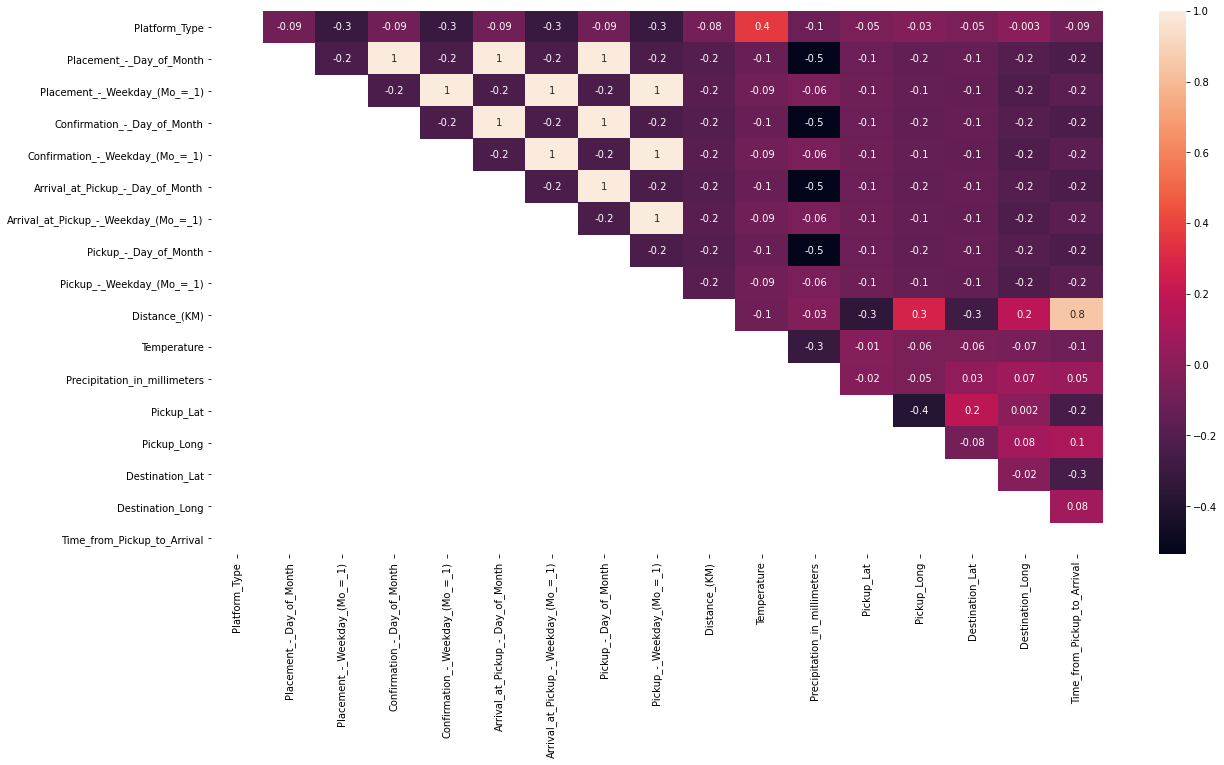

In [185]:
plt.figure(figsize=(20,10))
data = df.corr()
mask = np.tril(data)
sns.heatmap(data.corr(), annot = True, fmt='.1g', mask= mask)

In [186]:
df= df.drop(['Placement_-_Time','Confirmation_-_Time', 'Arrival_at_Pickup_-_Time', 'Pickup_-_Time'],axis=1) 

In [187]:
df= df.drop(['Rider_Id'],axis=1) 

In [188]:
def scatter_plot(feature, target):
  plt.figure(figsize=(10,5))
  plt.scatter(
      data[feature],
      data[target],
      c='black'
  )
  plt.xlabel("Feature".format(feature))
  plt.show()

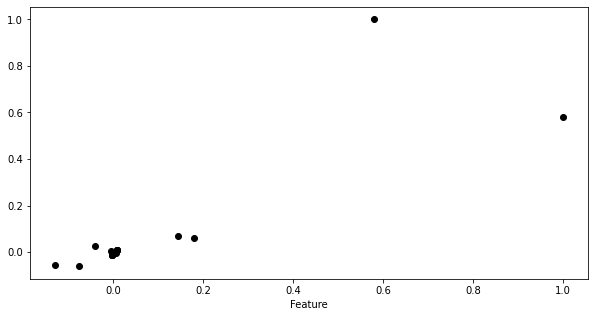

In [189]:
scatter_plot('Distance_(KM)', 'Time_from_Pickup_to_Arrival')

In [190]:
df.isnull().sum()

Platform_Type                               0
Personal_or_Business                        0
Placement_-_Day_of_Month                    0
Placement_-_Weekday_(Mo_=_1)                0
Confirmation_-_Day_of_Month                 0
Confirmation_-_Weekday_(Mo_=_1)             0
Arrival_at_Pickup_-_Day_of_Month            0
Arrival_at_Pickup_-_Weekday_(Mo_=_1)        0
Pickup_-_Day_of_Month                       0
Pickup_-_Weekday_(Mo_=_1)                   0
Distance_(KM)                               0
Temperature                              5803
Precipitation_in_millimeters            27518
Pickup_Lat                                  0
Pickup_Long                                 0
Destination_Lat                             0
Destination_Long                            0
Time_from_Pickup_to_Arrival              7068
dtype: int64

In [191]:
df['Temperature'].fillna((df['Temperature'].mean()), inplace=True)

In [192]:
df['Precipitation_in_millimeters'].fillna((df['Precipitation_in_millimeters'].mean()), inplace=True)

In [193]:
df["Personal_or_Business"] = pd.get_dummies(df["Personal_or_Business"],prefix='Personal_or_Business',drop_first=True)

In [194]:
df.head()

,Platform_Type,Personal_or_Business,Placement_-_Day_of_Month,Placement_-_Weekday_(Mo_=_1),Confirmation_-_Day_of_Month,Confirmation_-_Weekday_(Mo_=_1),Arrival_at_Pickup_-_Day_of_Month,Arrival_at_Pickup_-_Weekday_(Mo_=_1),Pickup_-_Day_of_Month,Pickup_-_Weekday_(Mo_=_1),Distance_(KM),Temperature,Precipitation_in_millimeters,Pickup_Lat,Pickup_Long,Destination_Lat,Destination_Long,Time_from_Pickup_to_Arrival
0,3,0,9,5,9,5,9,5,9,5,4,20.400000,7.573502,-1.317755,36.830370,-1.300406,36.829741,745.0
1,3,1,12,5,12,5,12,5,12,5,16,26.400000,7.573502,-1.351453,36.899315,-1.295004,36.814358,1993.0
2,3,0,30,2,30,2,30,2,30,2,3,23.255689,7.573502,-1.308284,36.843419,-1.300921,36.828195,455.0
3,3,0,15,5,15,5,15,5,15,5,9,19.200000,7.573502,-1.281301,36.832396,-1.257147,36.795063,1341.0
4,1,1,13,1,13,1,13,1,13,1,9,15.400000,7.573502,-1.266597,36.792118,-1.295041,36.809817,1214.0


In [195]:
# train test split
y = df[:len(train_df)][['Time_from_Pickup_to_Arrival']]
x_train = df[:len(train_df)].drop('Time_from_Pickup_to_Arrival',axis=1)
x_test = df[len(train_df):].drop('Time_from_Pickup_to_Arrival',axis=1)
x = df[:len(train_df)].drop('Time_from_Pickup_to_Arrival',axis=1)

# **Modelling**

Linear Regression

In [196]:
lr = LinearRegression()
####try different models on different versions, go wild! to see results

In [197]:
# Using just the training dataset to test model accuracy 
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test= train_test_split(x, y, test_size= 0.2, random_state=42) 

In [198]:
lr.fit(x_train,y_train)

preds = lr.predict(x_test)

In [199]:
def rmse(y_test, y_predict):
    return np.sqrt(mean_squared_error(y_test, y_predict))

In [200]:
rmse(y_test, preds)

803.7792759509722

In [201]:
from sklearn.metrics import r2_score

In [202]:
r2_score(y_test, preds) 
### checking for accuracy

0.3348558522373718

Ridge Regression

In [203]:
rdg = Ridge(alpha=1.0)

In [204]:
# Using just the training dataset to test model accuracy 
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test= train_test_split(x, y, test_size= 0.2, random_state=42) 

In [205]:
rdg.fit(x_train,y_train)

preds = rdg.predict(x_test)

In [206]:
def rmse(y_test, y_predict):
    return np.sqrt(mean_squared_error(y_test, y_predict))

In [207]:
rmse(y_test, preds)

803.8211253628501

In [208]:
from sklearn.metrics import r2_score

In [209]:
r2_score(y_test, preds) 
### checking for accuracy

0.3347865879085201

Lasso Regression

In [210]:
ls = Lasso()

In [211]:
# Using just the training dataset to test model accuracy 
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test= train_test_split(x, y, test_size= 0.2, random_state=42) 

In [212]:
ls.fit(x_train,y_train)

preds = ls.predict(x_test)

In [213]:
def rmse(y_test, y_predict):
    return np.sqrt(mean_squared_error(y_test, y_predict))

In [214]:
rmse(y_test, preds)

805.0997906731556

In [215]:
from sklearn.metrics import r2_score

In [216]:
r2_score(y_test, preds) 
### checking for accuracy

0.3326685499160591

Decision Tree Regression

In [217]:
sc = StandardScaler()
x_sc = sc.fit_transform(x)

In [218]:
dtr = DecisionTreeRegressor(random_state=42)

In [219]:
# Using just the training dataset to test model accuracy 
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test= train_test_split(x, y, test_size= 0.2, random_state=42) 

In [220]:
dtr.fit(x_train, y_train)

preds = dtr.predict(x_test)

In [221]:
def rmse(y_test, y_predict):
    return np.sqrt(mean_squared_error(y_test, y_predict))

In [222]:
rmse(y_test, preds)

1164.8216167210974

In [223]:
from sklearn.metrics import r2_score

In [224]:
r2_score(y_test, preds) 
### checking for accuracy

-0.3968861413833742

Random Forest Regression

In [225]:
sc = StandardScaler()
x_sc = sc.fit_transform(x)

In [226]:
x_train, x_test, y_train,y_test = train_test_split(x_sc,y,test_size=0.2,random_state= 42)

In [227]:
regressor = RandomForestRegressor(n_estimators= 120, random_state= 42)
####try different models on different versions

In [228]:
regressor.fit(x_train, y_train)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=120, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [229]:
y_predict = regressor.predict(x_test)

In [230]:
def rmse(y_test, y_predict):
    return np.sqrt(mean_squared_error(y_test, y_predict))

In [231]:
rmse(y_test, y_predict)

808.2582241088767

In [232]:
from sklearn.metrics import r2_score

In [233]:
r2_score(y_test, y_predict) 

0.32742235231164185

Polynomial Regression

In [235]:
poly_reg = PolynomialFeatures(degree=4)
X_poly = poly_reg.fit_transform(x)
pol_reg = LinearRegression()
pol_reg.fit(X_poly, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [237]:
pol_reg.predict(poly_reg.fit_transform(x_test))

array([[-1.57506795e+10],
       [ 3.71572080e+09],
       [-1.83515576e+10],
       ...,
       [-2.20120443e+10],
       [-1.14600994e+09],
       [-2.39432899e+10]])

In [238]:
def rmse(y_test, y_predict):
    return np.sqrt(mean_squared_error(y_test, y_predict))

In [239]:
rmse(y_test, preds)

1164.8216167210974

In [240]:
from sklearn.metrics import r2_score

In [241]:
r2_score(y_test, preds) 
### checking for accuracy

-0.3968861413833742

Logistic Regression

In [243]:
log_reg = LogisticRegression(solver='liblinear', random_state=0)

In [254]:
log_reg.fit(x_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [255]:
preds = log_reg.predict(x_test)

In [256]:
def rmse(y_test, y_predict):
    return np.sqrt(mean_squared_error(y_test, y_predict))

In [257]:
rmse(y_test, preds)

1457.5871890153612

In [258]:
from sklearn.metrics import r2_score

In [259]:
r2_score(y_test, preds) 
### checking for accuracy

-1.1873145932884093

Support Vector Regression

In [263]:
sc = StandardScaler()
sc_X = StandardScaler()
sc_y = StandardScaler()
X = sc_X.fit_transform(x)
y = sc_y.fit_transform(y)

In [264]:
sr = SVR(kernel='rbf')
####try different models on different versions

In [266]:
sr.fit(x_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [267]:
y_predict = sr.predict(x_test)

In [268]:
def rmse(y_test, y_predict):
    return np.sqrt(mean_squared_error(y_test, y_predict))

In [269]:
rmse(y_test, y_predict)

921.5957006797407

In [270]:
from sklearn.metrics import r2_score

In [271]:
r2_score(y_test, y_predict) 

0.12557403394061262